In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [22]:
latent_dim = 64  # Размерность латентного пространства
batch_size = 16
epochs = 15

In [23]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

cifar10_class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [24]:
encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = keras.backend.shape(z_mean)[0]
        dim = keras.backend.shape(z_mean)[1]
        epsilon = keras.backend.random_normal(shape=(batch, dim))
        return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [25]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8*8*128, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv2DTranspose(32, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [26]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            beta = 0.01
            total_loss = reconstruction_loss + beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

In [27]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - kl_loss: 105.6824 - reconstruction_loss: 21.4598 - total_loss: 22.5166
Epoch 2/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - kl_loss: 139.6333 - reconstruction_loss: 9.2627 - total_loss: 10.6591
Epoch 3/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - kl_loss: 140.3146 - reconstruction_loss: 8.6447 - total_loss: 10.0478
Epoch 4/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - kl_loss: 139.3747 - reconstruction_loss: 8.4123 - total_loss: 9.8060
Epoch 5/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - kl_loss: 138.7033 - reconstruction_loss: 8.2238 - total_loss: 9.6108
Epoch 6/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - kl_loss: 138.0575 - reconstruction_loss: 8.0887 - total_loss: 9.4693
Epoch 7/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - kl_loss: 137.9340 - reconstruction_loss: 7.9609 - total_loss: 9.3403
Epoch 8/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - kl_loss: 137.7047 - reconstruction_loss: 7.8814 - total_l

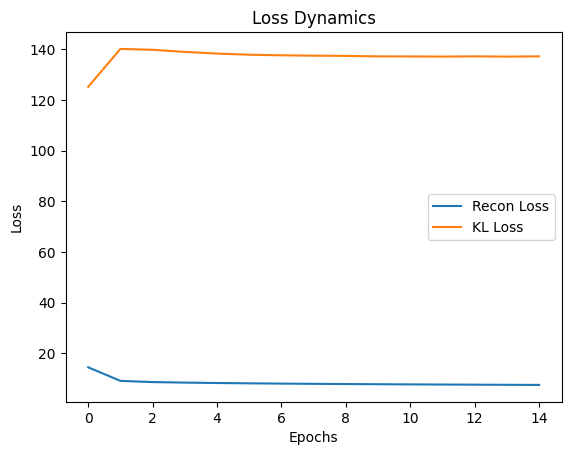

In [28]:
plt.plot(vae.history.history['reconstruction_loss'], label='Recon Loss')
plt.plot(vae.history.history['kl_loss'], label='KL Loss')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


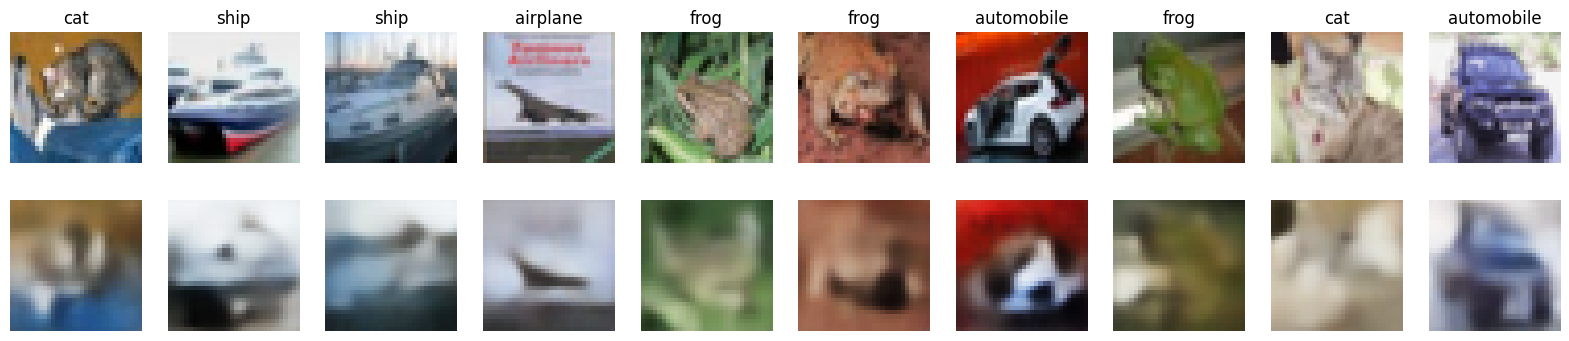

In [29]:
test_reconstructions = vae.decoder.predict(encoder.predict(x_test[:10])[2], verbose=0)
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i])
    plt.title(f"{cifar10_class_names[y_test[i][0]]}")
    plt.axis("off")

    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(test_reconstructions[i])
    plt.axis("off")
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


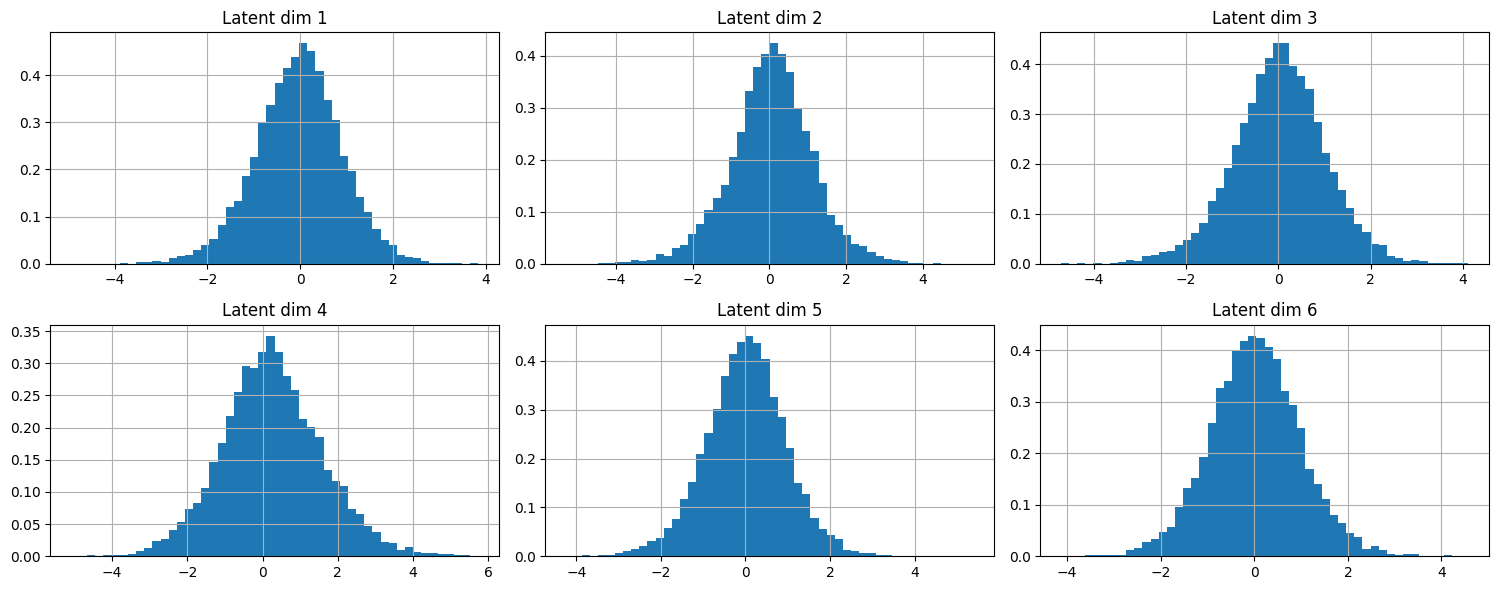

In [30]:
_, _, latent_vectors = encoder.predict(x_test, batch_size=128, verbose=1)
# Визуализация распределения случайных 6 компонент латентного пространства (оно нормальное, а значит всё хорошо)
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist(latent_vectors[:, np.random.randint(0, latent_dim)], bins=50, density=True)
    plt.title(f"Latent dim {i+1}")
    plt.grid(True)
plt.tight_layout()
plt.show()

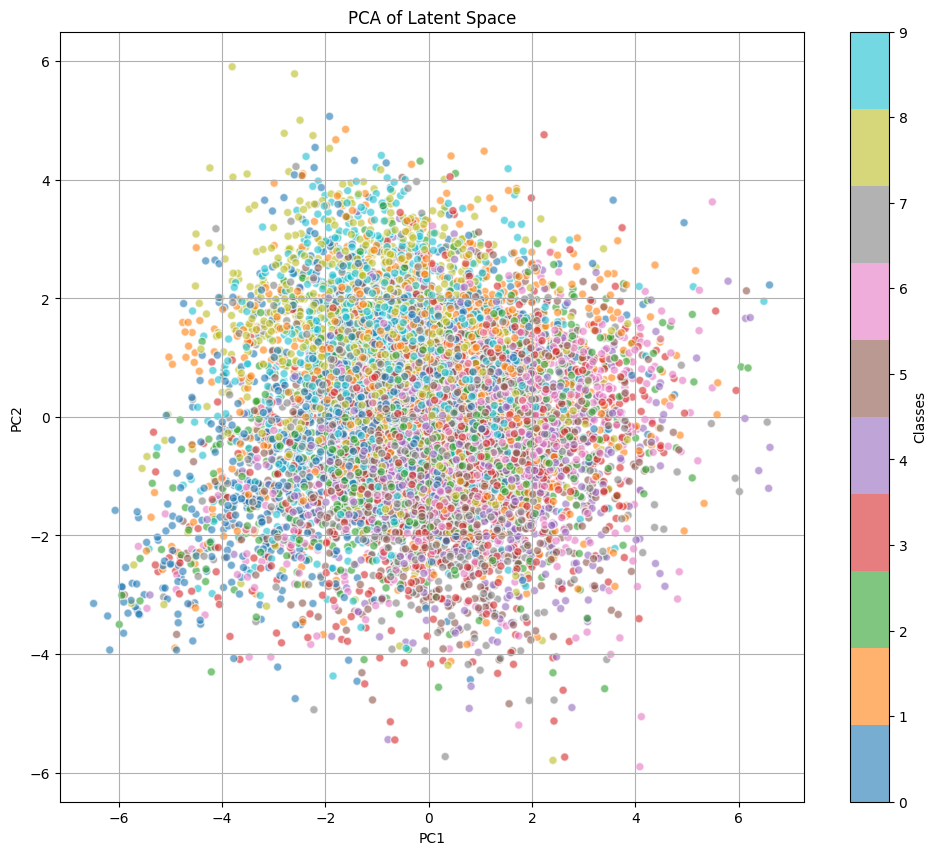

In [31]:
from sklearn.decomposition import PCA

# Проекция на 2 главные компоненты
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

# Визуализация
plt.figure(figsize=(12, 10))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test.flatten(),
            cmap='tab10', alpha=0.6, edgecolors='w')
plt.colorbar(ticks=range(10), label='Classes')
plt.title("PCA of Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
# Визуализация проекций картинок на две главные компоненты в латентном пространстве автоэнкодера показывает, что все изображения находятся в ограниченной области и распределны нормально

In [32]:
class_means = []
for class_idx in range(10):
    class_images = x_train[y_train.flatten() == class_idx]
    _, _, latent_vectors = encoder.predict(class_images, verbose=0)
    class_means.append(np.mean(latent_vectors, axis=0))

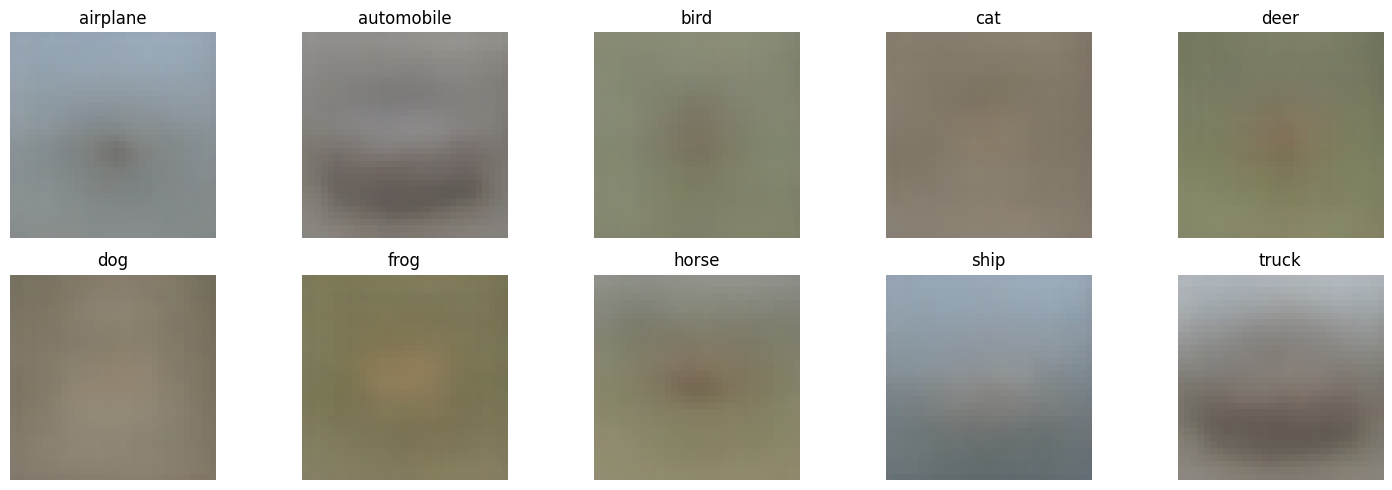

In [33]:
plt.figure(figsize=(15, 5))
for class_idx in range(10):
    # Получаем средний вектор класса
    mean_vector = class_means[class_idx]
    
    # Декодируем его в изображение (без шума!)
    generated_image = decoder.predict(mean_vector[np.newaxis, ...], verbose=0)[0]
    
    # Визуализация
    plt.subplot(2, 5, class_idx + 1)
    plt.imshow(generated_image)
    plt.title(f"{cifar10_class_names[class_idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [34]:
noise_scale = 0.85
generated_images = []
generated_labels = []

for class_idx in range(10):
    # Генерируем все векторы для класса одним вызовом
    mean_vector = class_means[class_idx]
    temp = 1
    noise = temp * np.random.normal(scale=noise_scale, size=(5000, latent_dim))
    #print(noise)
    latent_vectors = mean_vector + noise
    
    # Декодируем батчами по 256
    class_images = []
    for batch in np.array_split(latent_vectors, 5000//256 + 1):
        images = decoder.predict(batch, verbose=0)
        class_images.append(images)
    
    generated_images.append(np.concatenate(class_images))
    generated_labels.extend([class_idx]*5000)

generated_images = np.concatenate(generated_images)
generated_labels = np.array(generated_labels)

print(generated_images.shape)  # Должно быть (50000, 32, 32, 3)
print(generated_labels.shape)  # Должно быть (50000,)

(50000, 32, 32, 3)
(50000,)


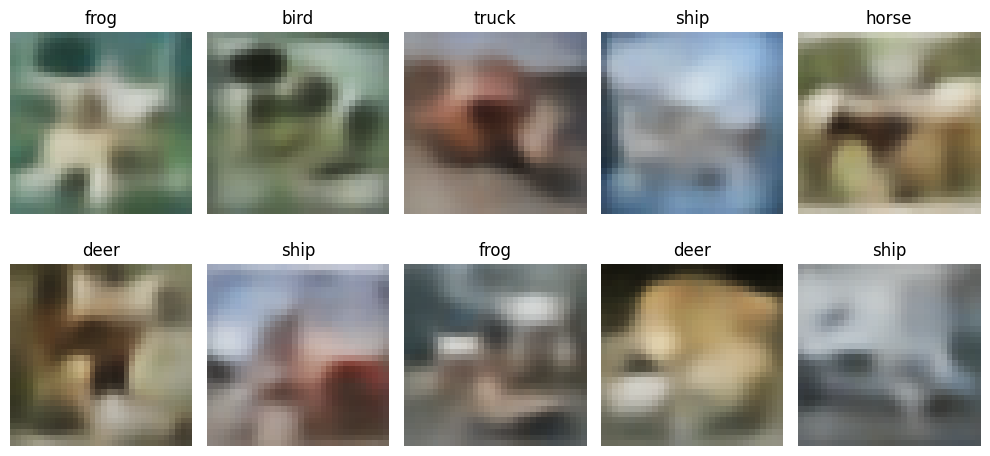

In [43]:
import random

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    idx = random.randint(0, len(generated_images)-1)
    plt.imshow(generated_images[idx])
    plt.title(f"{cifar10_class_names[generated_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [36]:
generated_labels_onehot = to_categorical(generated_labels, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)

In [37]:
model = keras.Sequential([
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units=1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
#print(model.summary())

# Компиляция нейросети (выбор оптимизатора, функции ошибки и характеристики точности нейросети)
#my_optimizer = keras.optimizers.SGD(learning_rate = 0.01, nesterov = True)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Остановка обучения, если точность в выборке валидации долго не изменяется
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='auto',
    patience=5,
    verbose=1
)

In [39]:
history = model.fit(generated_images, generated_labels_onehot,
                    epochs=40,
                    batch_size=60,
                    validation_data=(x_test, y_test_onehot))

Epoch 1/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 59s 53ms/step - accuracy: 0.3240 - loss: 2.1829 - val_accuracy: 0.2507 - val_loss: 3.3248
Epoch 2/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4062 - loss: 1.6188 - val_accuracy: 0.2833 - val_loss: 2.7532
Epoch 3/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.4208 - loss: 1.5908 - val_accuracy: 0.3369 - val_loss: 2.3107
Epoch 4/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.4397 - loss: 1.5472 - val_accuracy: 0.3001 - val_loss: 2.6296
Epoch 5/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.4396 - loss: 1.5457 - val_accuracy: 0.3465 - val_loss: 2.1454
Epoch 6/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.4470 - loss: 1.5306 - val_accuracy: 0.3363 - val_loss: 2.3060
Epoch 7/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.4497 - loss: 1.5185 - val_accuracy: 0.3192 - val_loss: 2.2838
Epoch 8/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.4577 - loss: 1.4973 - 

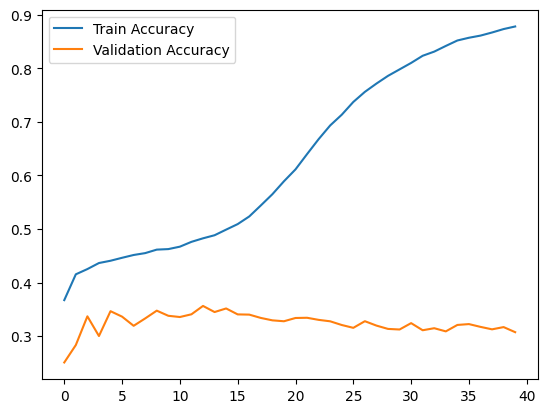

In [40]:
# Визуализация результатов
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()